# Naive Bayes Multinomial (Sentiment Review Prediction)
Penjelasan Kolom:
1. Reviews: Teks lengkap dari ulasan yang ditulis oleh pengguna.
2. Ratings: Jumlah bintang (rating) yang diberikan pengguna. Nilai berkisar dari 1 hingga 5.

## A. Data Preparation

### A.1 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### A.2 Load Data

In [2]:
import pandas as pd
import numpy as np

# 1. Load Data
df = pd.read_csv('Call Of Duty.csv')

# --- TAMBAHAN PENTING: MANUAL VECTORIZATION ---
# A. Bersihkan Teks (Tanpa Regex)
df['clean_reviews'] = df['reviews'].str.lower()
tanda_baca = '''!()-[]{};:'",<>./?@#$%^&*_~'''
for char in tanda_baca:
    df['clean_reviews'] = df['clean_reviews'].str.replace(char, ' ', regex=False)

# B. Pecah jadi kata (Tokenizing)
df['words'] = df['clean_reviews'].str.split()

# C. Bikin Kamus Kata (Vocab)
all_words = []
for words_list in df['words']:
    if isinstance(words_list, list):
        all_words.extend(words_list)
vocab = sorted(list(set(all_words)))

# D. Bikin Matriks Angka (Bag of Words)
# Kita buat wadah kosong dulu
X_matrix = np.zeros((len(df), len(vocab)), dtype=int)
word_to_idx = {word: i for i, word in enumerate(vocab)}

# Isi wadah dengan angka 1 jika kata muncul
for i, words_list in enumerate(df['words']):
    if isinstance(words_list, list):
        for word in words_list:
            if word in word_to_idx:
                X_matrix[i, word_to_idx[word]] = 1

# E. Simpan jadi DataFrame agar mudah displit
df_vectorized = pd.DataFrame(X_matrix, columns=vocab)

print("Data sudah diubah jadi angka. Ukuran:", df_vectorized.shape)

Data sudah diubah jadi angka. Ukuran: (3882, 8855)


### A.3 Mengecek Dimensi Data

In [3]:
df.shape

(3882, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3882 entries, 0 to 3881
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reviews        3882 non-null   object
 1   ratings        3882 non-null   int64 
 2   clean_reviews  3882 non-null   object
 3   words          3882 non-null   object
dtypes: int64(1), object(3)
memory usage: 121.4+ KB


In [5]:
df.head()

,reviews,ratings,clean_reviews,words
0,I've been playing for years now and it's been ...,4,i ve been playing for years now and it s been ...,"[i, ve, been, playing, for, years, now, and, i..."
1,An annoying experience all round. Ever since t...,1,an annoying experience all round ever since t...,"[an, annoying, experience, all, round, ever, s..."
2,"I love the game though. It's close to real, bu...",3,i love the game though it s close to real bu...,"[i, love, the, game, though, it, s, close, to,..."
3,I've been playing for years now and it's been ...,4,i ve been playing for years now and it s been ...,"[i, ve, been, playing, for, years, now, and, i..."
4,An annoying experience all round. Ever since t...,1,an annoying experience all round ever since t...,"[an, annoying, experience, all, round, ever, s..."


## B. Data Preprocessing

In [6]:
def clean_text(text):
    if not isinstance(text, str): return ""
    
    text = text.lower()
    text = str.replace(r'[^a-z\s]', '', regex=True)
    text = text.strip()
    
    return text

## C. Exploratory Data Analysis (EDA)

### C.1 Mengecek Sample Target (Rating)

In [7]:
df.columns

Index(['reviews', 'ratings', 'clean_reviews', 'words'], dtype='object')

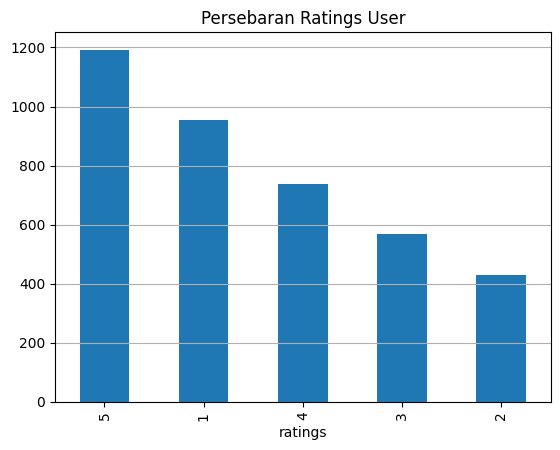

In [8]:
df['ratings'].value_counts().plot(kind='bar').set_title("Persebaran Ratings User")
plt.grid(axis='y')
plt.show()

### C.2 Mengecek Korelasi Reviews dengan Ratings

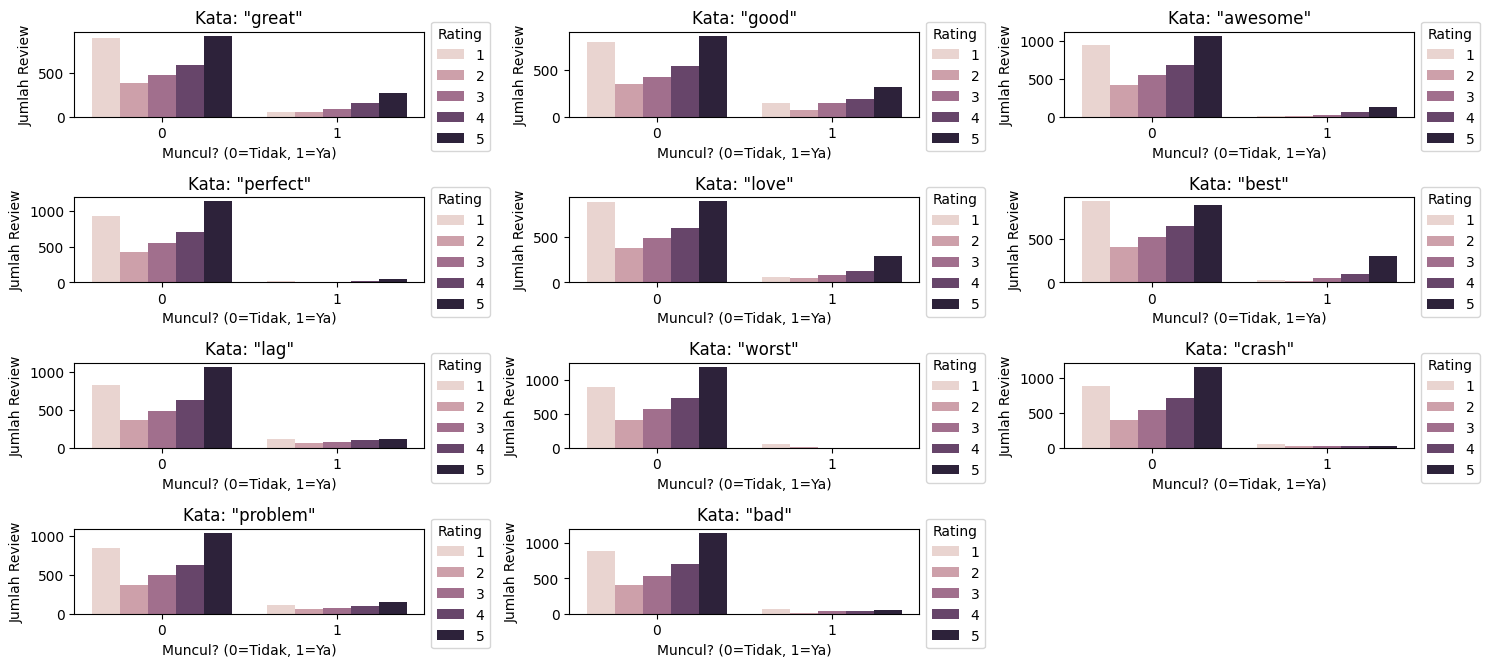

In [9]:
review_words = ['great','good','awesome','perfect','love','best','lag','worst','crash', 'problem', 'bad']
target = 'ratings'

plt.figure(figsize=(15, 8))

for i, kata in enumerate(review_words):
    # Langkah A: Bikin kolom baru (0 jika gak ada, 1 jika ada)
    # Kita pakai str(x).lower() biar "Good" dan "good" dianggap sama
    df[kata] = df['reviews'].apply(lambda x: 1 if kata in str(x).lower() else 0)
    
    # Langkah B: Gambar Grafik di posisi yang benar
    plt.subplot(5, 3, i + 1)
    sns.countplot(x=kata, hue=target, data=df)
    plt.legend(title='Rating', bbox_to_anchor=(1, 1.2))
    plt.title(f'Kata: "{kata}"')
    plt.xlabel(f'Muncul? (0=Tidak, 1=Ya)')
    plt.ylabel('Jumlah Review')

plt.tight_layout()
plt.show()

## D. Modelling

### D.1 Membuat Variabel X dan Y

In [10]:
X = df_vectorized  
y = df['ratings']

### D.2 Splitting Data Training dan Data Test

In [11]:
def stratified_split_data(X, y, train_size=0.8, random_state=42, frac=None):
    np.random.seed(random_state)
    
    if frac:
        X = X.sample(frac=frac, random_state=random_state)
        y = y.loc[X.index]
        
    X_train_list, X_test_list = [], []
    y_train_list, y_test_list = [], []
    
    for class_value in np.unique(y):
        class_idx = np.where(y == class_value)[0]
        
        idx = np.random.permutation(class_idx)
        split_ratio = int(len(idx) * train_size)
        
        X_train_list.append(X.iloc[idx[:split_ratio]])
        X_test_list.append(X.iloc[idx[split_ratio:]])
        y_train_list.append(y.iloc[idx[:split_ratio]])
        y_test_list.append(y.iloc[idx[split_ratio:]])
        
    X_train = pd.concat(X_train_list).reset_index(drop=True)
    X_test = pd.concat(X_test_list).reset_index(drop=True)
    y_train = pd.concat(y_train_list).reset_index(drop=True)
    y_test = pd.concat(y_test_list).reset_index(drop=True)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = stratified_split_data(X, y )

print("Shape X_train:", X_train.shape) 
# Sekarang outputnya pasti (jumlah_baris, jumlah_vocab), misal (3105, 9600).
# Error "unpack" tidak akan muncul lagi karena sudah 2 Dimensi.

Shape X_train: (3104, 8855)


### D.3 Membuat Class NaiveBayesMultinomial

In [12]:
class NaiveBayesMultinomial:
    def __init__(self, alpha=3):
        self.alpha = alpha
    
    def fit(self, X, y):
        # Karena X_train kita DataFrame, kita ubah ke numpy array untuk perhitungan matematika
        X_data = X.values if isinstance(X, pd.DataFrame) else X
        y_data = y.values if isinstance(y, pd.Series) else y
        
        n_samples, n_features = X_data.shape
        self._classes = np.unique(y_data)
        n_classes = len(self._classes)
        
        # AMBIL VOCAB DARI NAMA KOLOM DATAFRAME
        if isinstance(X, pd.DataFrame):
            self.vocabulary = X.columns.tolist()
        else:
            self.vocabulary = np.arange(n_features).astype(str).tolist()

        # Hitung prior & likelihood
        self._priors = np.zeros(n_classes, dtype=np.float64)
        self._feature_probs = np.zeros((n_classes, n_features), dtype=np.float64)
        
        for idx, c in enumerate(self._classes):
            X_c = X_data[y_data == c]
            self._priors[idx] = X_c.shape[0] / float(n_samples)
            total_count_per_word = X_c.sum(axis=0)
            total_word_in_class = X_c.sum()
            numerator = total_count_per_word + self.alpha
            denominator = total_word_in_class + (self.alpha * n_features)
            
            self._feature_probs[idx, :] = numerator / denominator
            
    def predict(self, X):
        X_data = X.values if isinstance(X, pd.DataFrame) else X
        y_pred = [self._predict_one(x) for x in X_data]
        return np.array(y_pred)
    
    def predict_single(self, text):
        if not isinstance(text, str): return ""
        
        # 1. Cleaning Manual (Tanpa Regex)
        text_clean = text.lower()
        tanda_baca = '''!()-[]{};:'",<>./?@#$%^&*_~'''
        for char in tanda_baca:
            text_clean = text_clean.replace(char, " ")
            
        words_user = text_clean.split()
        
        # 2. Vectorizing
        # Cek kata per kata
        vector_input = np.array([1 if kata in words_user else 0 for kata in self.vocabulary])
        
        # 3. Prediksi
        return self._predict_one(vector_input)
    
    def _predict_one(self, x):
        posteriors = []
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            likelihood = np.sum(x * np.log(self._feature_probs[idx]))
            posterior = prior + likelihood
            posteriors.append(posterior)
        return self._classes[np.argmax(posteriors)]

## E. Evaluasi Model

### E.1 Evaluasi Akurasi Test & Train

In [13]:
nbm = NaiveBayesMultinomial(3)
nbm.fit(X_train, y_train) 
print("nbm berhasil dilatih!")

nbm berhasil dilatih!


In [14]:
predictions = nbm.predict(X_test)

In [15]:
test_accuracy = np.sum(predictions == y_test) / len(X_test)
test_accuracy

np.float64(0.4717223650385604)

In [16]:
predictions_train = nbm.predict(X_train.values)

In [17]:
train_accuracy = np.sum(predictions_train == y_train) / len(X_train)
print(train_accuracy)

0.5283505154639175


### E.2 Evaluasi Precision, Recall, Confusion Matrix

In [18]:
# 1. Buat Confusion Matrix Otomatis (Multiclass)
# Ini akan membuat tabel 6x6 (Baris=Asli, Kolom=Prediksi)
cm_df = pd.crosstab(y_test, predictions, rownames=['Aktual'], colnames=['Prediksi'])

print("--- Confusion Matrix ---")
print(cm_df)

# 2. Hitung Akurasi Manual dari Tabel
# Jumlahkan diagonal utama (yang benar) dibagi total data
diag = np.diag(cm_df) # Ambil angka diagonal (1-1, 2-2, dst)
total_benar = np.sum(diag)
total_data = np.sum(cm_df.values)

akurasi = total_benar / total_data
print(f"\nAkurasi Total: {akurasi:.2%}")

# 3. Hitung Precision & Recall per Kelas (Opsional tapi Keren)
# Precision = Diagonal / Total Kolom
# Recall = Diagonal / Total Baris
print("\n--- Detail per Kelas ---")
for label in cm_df.index:
    # TP = Angka di diagonal untuk label ini
    TP = cm_df.loc[label, label]
    
    # FN = Total Baris dikurangi TP
    Total_Asli = cm_df.loc[label].sum()
    FN = Total_Asli - TP
    
    # FP = Total Kolom dikurangi TP
    Total_Prediksi = cm_df[label].sum()
    FP = Total_Prediksi - TP
    
    # Hitung
    prec = TP / (TP + FP) if (TP + FP) > 0 else 0
    rec = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    print(f"Kelas {label} -> Precision: {prec:.2f}, Recall: {rec:.2f}")

--- Confusion Matrix ---
Prediksi    1  4    5
Aktual               
1         141  0   50
2          52  0   34
3          38  1   75
4          30  2  116
5          15  0  224

Akurasi Total: 27.76%

--- Detail per Kelas ---
Kelas 1 -> Precision: 0.51, Recall: 0.74


KeyError: 2

### E.3 Evaluasi Data Baru (GUI)

In [19]:
import tkinter as tk
from tkinter import *
from tkinter import messagebox


try:
    model = nbm
    print("Berhasil memanggil model")
except Exception as e:
    model = None
    print("Gagal mengambil model")

def cek_data_baru():
    data_baru = entry_data.get("1.0", tk.END).strip()
        
    if not data_baru:
        messagebox.showwarning('Input kosong', 'tolong input data yang benar')
        return
    
    hasil = model.predict_single(data_baru)
        
    label_hasil.config(text=f"Rating: {hasil}", fg='blue')

# GUI UTAMA
root = tk.Tk()

root.title("Prediksi Naive Bayes Multinomial")
root.geometry("700x600")
root.configure(bg="lightblue")

judul = Label(root,text="Prediksi Sentimen Review", font=("Arial", 20, "bold"), bg="lightblue")
judul.pack()

deskripsi = Label(root,text="Naive Bayes Multinomial", font=("Arial", 10, "underline"), bg="lightblue")
deskripsi.pack(pady=(0, 30))

entry_data = Text(root, width=40, height=20, bg="gray", fg="white")
entry_data.pack()

enter_data = Button(text="Kirim Teks", command=cek_data_baru)
enter_data.pack(pady=30)

label_hasil = Label(text="...")
label_hasil.pack()

root.mainloop()

Berhasil memanggil model
